# Data Analysis

In [12]:
import numpy as np
import pandas as pd
import ezodf

def read_ods(filename, sheet_no=0, header=0):
    tab = ezodf.opendoc(filename=filename).sheets[sheet_no]
    return pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                         for col in tab.columns()})

sfSens1=pd.read_csv("data/measure1_smartphone_sens.csv")
swSens1=pd.read_csv("data/measure1_smartwatch_sens.csv")
sfWifi1=pd.read_csv("data/measure1_smartphone_wifi.csv")
tstamp1=pd.read_csv("data/measure1_timestamp_id.csv", header=None, names = ['in', 'out', 'id'], sep=';')
points=read_ods(filename="data/PointsMapping.ods")
points=points.drop([None], axis=1)[:325]

In [55]:
"""
points['AREA'] = 1
if ((0<points['X']) & (points['X']<3) & (0<points['Y']) & (points['Y']<=5)):
    points['AREA'] = points['AREA']*2
if (0<points['X']) & (points['X']<19.5) & (5<points['Y']) & (points['Y']<7):
    points['AREA'] = points['AREA']*3
if (19.5<points['X']) & (points['X']<24.3):
    points['AREA'] = points['AREA']*4
if (24.3<points['X']) & (points['X']<35) & (5<points['Y']) & (points['Y']<7):
    points['AREA'] = points['AREA']*5
if (35<points['X']) & (points['X']<37) & (4.5<points['Y']) & (points['Y']<37):
    points['AREA'] = points['AREA']*6
"""

"\npoints['AREA'] = 1\nif ((0<points['X']) & (points['X']<3) & (0<points['Y']) & (points['Y']<=5)):\n    points['AREA'] = points['AREA']*2\nif (0<points['X']) & (points['X']<19.5) & (5<points['Y']) & (points['Y']<7):\n    points['AREA'] = points['AREA']*3\nif (19.5<points['X']) & (points['X']<24.3):\n    points['AREA'] = points['AREA']*4\nif (24.3<points['X']) & (points['X']<35) & (5<points['Y']) & (points['Y']<7):\n    points['AREA'] = points['AREA']*5\nif (35<points['X']) & (points['X']<37) & (4.5<points['Y']) & (points['Y']<37):\n    points['AREA'] = points['AREA']*6\n"

In [54]:
#if ((0<points['X']) & (points['X']<3) & (0<points['Y']) & (points['Y']<=5)):
#https://blog.modeanalytics.com/python-data-visualization-libraries/
#https://python-graph-gallery.com/

<IPython.core.display.Javascript object>


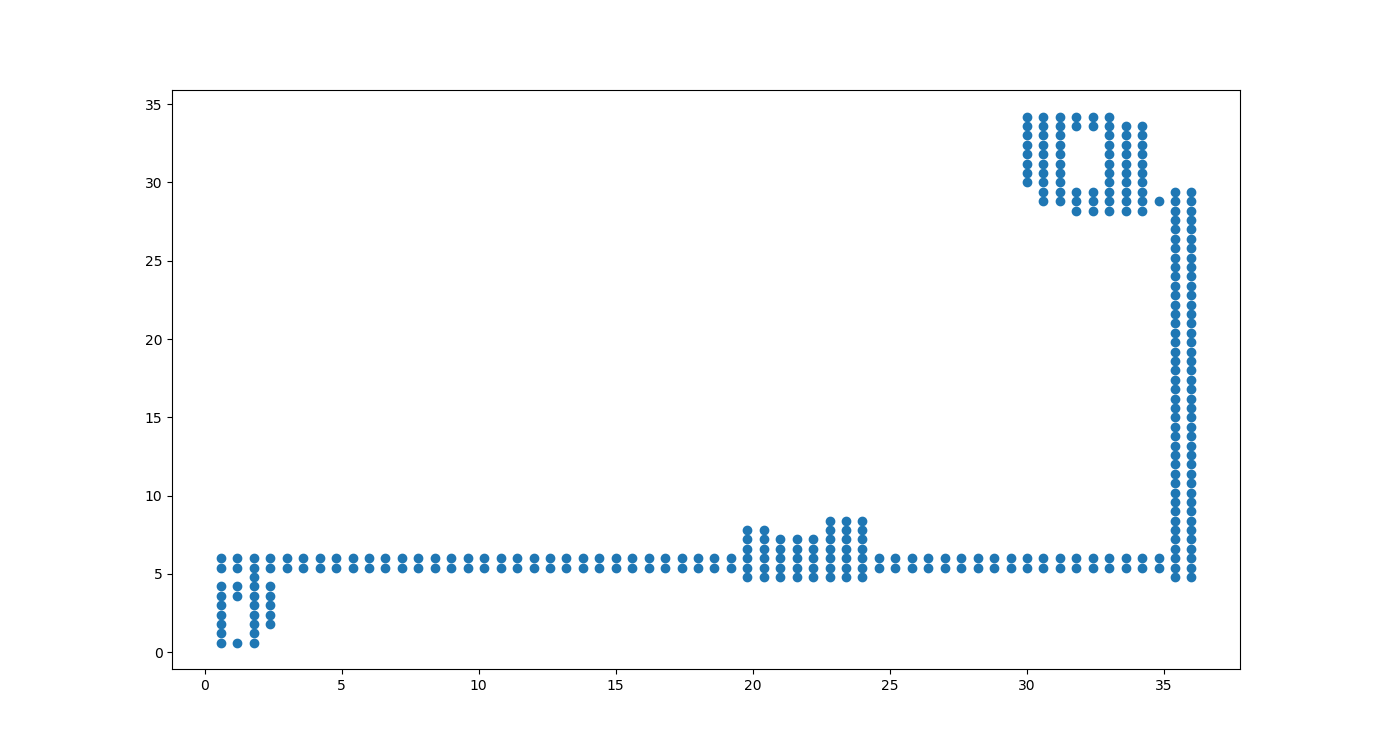

In [27]:
#display(tstamp1.head())
#display(tstamp1.describe())
#tstamp1['id'].value_counts(sort=True, ascending=False)
#tstamp1.sort_values(['id'], ascending=[1])

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
plt.scatter(points['X'], points['Y'])
plt.show()

In [15]:
display(sfSens1.head())
display(sfSens1.describe())
display(swSens1.head())
display(swSens1.describe())

,timestamp,AccelerationX,AccelerationY,AccelerationZ,MagneticFieldX,MagneticFieldY,MagneticFieldZ,Z-AxisAgle(Azimuth),X-AxisAngle(Pitch),Y-AxisAngle(Roll),GyroX,GyroY,GyroZ
0,1422629483421,-3.577,2.104,9.078,-5.4,-17.9,-28.2,126.404,-12.169,-21.001,0,0,0
1,1422629483520,-3.424,2.927,9.374,-4.3,-21.9,-26.9,134.694,-11.322,-25.898,0,0,0
2,1422629483620,-2.505,2.908,8.867,-0.7,-24.4,-26.5,150.906,-17.523,-15.017,0,0,0
3,1422629483723,-5.473,1.472,9.394,0.3,-25.7,-26.9,138.022,-21.068,-23.941,0,0,0
4,1422629483822,-3.414,2.018,8.187,3.7,-29.6,-23.9,163.519,-12.814,-22.046,0,0,0


,timestamp,AccelerationX,AccelerationY,AccelerationZ,MagneticFieldX,MagneticFieldY,MagneticFieldZ,Z-AxisAgle(Azimuth),X-AxisAngle(Pitch),Y-AxisAngle(Roll),GyroX,GyroY,GyroZ
count,1.835400e+04,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.000000,18354.0,18354.0,18354.0
mean,1.422859e+12,-0.296746,4.211019,8.288839,-1.157590,-7.415054,-29.640253,168.779099,-25.079180,-1.687723,0.0,0.0,0.0
std,1.796786e+08,1.172366,2.326193,1.587541,16.907053,21.466757,11.524140,114.797401,20.257369,7.512564,0.0,0.0,0.0
min,1.422629e+12,-11.563000,-14.702000,-3.285000,-85.900000,-103.300000,-59.800000,0.005000,-114.158000,-79.969000,0.0,0.0,0.0
25%,1.422632e+12,-0.675000,3.196000,7.919000,-15.400000,-27.000000,-38.100000,46.692750,-35.234000,-3.859000,0.0,0.0,0.0
50%,1.422884e+12,-0.331000,4.057000,8.513000,-7.800000,-5.500000,-31.600000,143.816000,-25.197000,-1.936000,0.0,0.0,0.0
75%,1.423044e+12,0.014000,5.724000,8.991000,16.100000,9.300000,-23.300000,307.210250,-19.470000,0.071000,0.0,0.0,0.0
max,1.423128e+12,14.914000,12.781000,14.747000,37.900000,53.100000,37.200000,359.989000,158.389000,80.325000,0.0,0.0,0.0


,timestamp,AccelerationX,AccelerationY,AccelerationZ,MagneticFieldX,MagneticFieldY,MagneticFieldZ,Z-AxisAgle(Azimuth),X-AxisAngle(Pitch),Y-AxisAngle(Roll),GyroX,GyroY,GyroZ
0,1422628680350,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1422628680445,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1422628680545,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1422628680645,0.200,3.653,8.763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1422628680744,0.235,3.691,8.867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,timestamp,AccelerationX,AccelerationY,AccelerationZ,MagneticFieldX,MagneticFieldY,MagneticFieldZ,Z-AxisAgle(Azimuth),X-AxisAngle(Pitch),Y-AxisAngle(Roll),GyroX,GyroY,GyroZ
count,5.837400e+04,58374.000000,58374.000000,58374.000000,58374.000000,58374.000000,58374.000000,58374.000000,58374.000000,58374.000000,58374.000000,58374.000000,58374.000000
mean,1.422827e+12,1.726072,-7.099805,1.906930,-4.769356,23.568268,0.892316,198.198215,71.880993,10.334409,-0.015220,-0.001513,-0.004305
std,1.798837e+08,4.561547,3.186476,3.317096,20.496038,16.323750,20.937565,126.326150,35.262366,30.202981,0.720377,0.401403,0.308089
min,1.422629e+12,-19.076000,-14.606000,-17.799000,-63.387000,-47.095000,-52.650000,0.000000,-178.445000,-85.213000,-11.303000,-7.641000,-5.946000
25%,1.422631e+12,-0.263000,-9.451000,0.468000,-21.028000,14.026000,-15.063000,74.352000,67.464750,-0.760000,-0.063000,-0.058000,-0.045000
50%,1.422872e+12,1.437500,-7.798000,1.725500,-6.133000,28.342000,2.563500,236.572000,78.120000,7.643500,-0.003000,0.001000,-0.003000
75%,1.423043e+12,5.690000,-6.381500,3.104000,9.082000,35.309000,17.557750,329.231000,85.835000,35.666000,0.059000,0.069000,0.040000
max,1.423128e+12,11.073000,11.105000,14.254000,56.525000,90.747000,58.643000,359.999000,177.019000,78.409000,11.146000,11.972000,4.735000


In [20]:
sfWifi1.T

,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
0,1,2,3,4,5,6,7,8,9,10,...,315,316,317,318,319,320,321,322,323,324
-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-100,-100,-82,-100,-100,-100,-100,-100,-69,-69
-100.1,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-100,-100,-86,-79,-100,-100,-100,-100,-69,-69
-100.2,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-37,-37,-49,-46,-52,-100,-52,-49,-50,-46
-100.3,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-37,-37,-49,-46,-52,-100,-51,-49,-49,-43
-82,-100,-90,-88,-80,-86,-81,-80,-86,-81,-85,...,-88,-84,-100,-100,-100,-100,-100,-100,-100,-100
-82.1,-100,-100,-87,-82,-86,-85,-79,-85,-86,-86,...,-100,-85,-100,-100,-100,-100,-100,-100,-100,-100
-100.4,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-72,-72,-69,-66,-66,-100,-76,-74,-75,-59
-100.5,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-69,-72,-67,-60,-66,-100,-77,-75,-76,-63
-100.6,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100


In [21]:
tstamp1

,ID,X,Y
0,1.0,0.6,0.6
1,2.0,1.2,0.6
2,3.0,1.8,0.6
3,4.0,0.6,1.2
4,5.0,1.8,1.2
5,6.0,0.6,1.8
6,7.0,1.8,1.8
7,8.0,2.4,1.8
8,9.0,0.6,2.4
9,10.0,1.8,2.4
